In [0]:
!pip install keras-metrics

In [0]:
# for plotting and looking at images
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

# data manipulation and handling
import numpy as np
import pandas as pd
import os
import pickle

# 
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras_metrics as km

# mount colab
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# data paths
path = r'/content/drive/My Drive/Colab Notebooks/datasets/ProcessedImages'
dnm = lambda x: 'segmented' if int(x) < 5 else 'resized'

# setup to control history here
scenario = '3a'
hist_path = r'/content/drive/My Drive/Colab Notebooks/models/classifiers/history_{}.pkl'.format(scenario)
model_path = r'/content/drive/My Drive/Colab Notebooks/models/classifiers/classifier_{}.h5'.format(scenario)

# get the dataset name
dataset_nm = dnm(scenario[:scenario.index('a')])

# read the datasets
arrnms = ['Xtrain', 'Ytrain', 'Xvalid', 'Yvalid', 'Xtest', 'Ytest']
datasets = dict()
print('Getting the {} data for training and testing'.format(dataset_nm))
for nm in arrnms:
    datasets[nm] = np.load(os.path.join(path, dataset_nm + '_' + nm + '.npy'))
    print(nm, datasets[nm].shape)

Getting the segmented data for training and testing
Xtrain (6009, 128, 128, 3)
Ytrain (6009,)
Xvalid (2003, 128, 128, 3)
Yvalid (2003,)
Xtest (2003, 128, 128, 3)
Ytest (2003,)


In [0]:
# Define the different hyperparameters and then apply based on the scenario
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD(lr=0.001)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.1,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            min_delta=0.0001,
                                            cooldown=0, min_lr=0)

# setup model parameters and run based on the scenario name
model_params = {
    '1a': dict(optimizer=sgd, lrr=None, batch_size=16, epochs=10),
    '2a': dict(optimizer=sgd, lrr=[learning_rate_reduction], batch_size=16, epochs=10),
    '3a': dict(optimizer=adam, lrr=None, batch_size=16, epochs=10),
    '4a': dict(optimizer=adam, lrr=[learning_rate_reduction], batch_size=16, epochs=10),
    '5a': dict(optimizer=sgd, lrr=None, batch_size=16, epochs=10),
    '6a': dict(optimizer=sgd, lrr=[learning_rate_reduction], batch_size=16, epochs=10),
    '8a': dict(optimizer=adam, lrr=None, batch_size=16, epochs=10),
    '9a': dict(optimizer=adam, lrr=[learning_rate_reduction], batch_size=16, epochs=10),
    '10a': dict(optimizer=sgd, lrr=None, batch_size=16, epochs=30),
    '11a': dict(optimizer=sgd, lrr=[learning_rate_reduction], batch_size=16, epochs=50)
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# how many of each class in our training set?
num_mel = datasets['Ytrain'].sum()
num_samples = len(datasets['Ytrain'])
weight = (num_samples-num_mel) / float(num_mel)
print('Class weight is {:.2f}'.format(weight))
print('Melanoma samples: {:.0f}, Non-melanoma samples: {:.0f}, Balanced: {:.0f}'.format(num_mel, num_samples-num_mel, weight*num_mel))
class_weight = {0:1.0, 1:weight}

Class weight is 7.92
Melanoma samples: 674, Non-melanoma samples: 5335, Balanced: 5335


In [0]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (128, 128, 3)

model = Sequential()

# Block one - does blah, blah
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Block two
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Block three
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
___________________________

In [0]:
# Compile the model
model.compile(optimizer=model_params[scenario]['optimizer'],
              loss="binary_crossentropy",
              metrics=[km.binary_recall(), km.binary_precision()])

In [0]:
# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(datasets['Xtrain'])

In [0]:
history = model.fit_generator(datagen.flow(datasets['Xtrain'], datasets['Ytrain'],
                                           batch_size=model_params[scenario]['batch_size']),
                              epochs = model_params[scenario]['epochs'],
                              validation_data = (datasets['Xvalid'],datasets['Yvalid']),
                              verbose = 2, steps_per_epoch=datasets['Xtrain'].shape[0],
                              class_weight=class_weight ,
                              callbacks=model_params[scenario]['lrr'])

pickle_out = open(hist_path,"wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 324s - loss: 1.2331 - recall: 0.5068 - precision: 0.1082 - val_loss: 0.6936 - val_recall: 1.0000 - val_precision: 0.1113
Epoch 2/10
 - 320s - loss: 1.2307 - recall: 0.4171 - precision: 0.1075 - val_loss: 0.6925 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
 - 320s - loss: 1.2315 - recall: 0.5025 - precision: 0.1074 - val_loss: 0.6946 - val_recall: 1.0000 - val_precision: 0.1113
Epoch 4/10
 - 320s - loss: 1.2308 - recall: 0.4780 - precision: 0.1077 - val_loss: 0.6925 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/10
 - 320s - loss: 1.2305 - recall: 0.4242 - precision: 0.1078 - val_loss: 0.6911 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 6/10
 - 324s - loss: 1.2311 - recall: 0.4808 - precision: 0.1069 - val_loss: 0.6926 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 7/10
 - 322s - loss: 1.2314 - recall: 0.4469 - precision: 0.1082 - val_loss: 0.6953 - val_recall: 1.0000

In [0]:
# get the test set stats
loss, recall, precision = model.evaluate(datasets['Xtest'], datasets['Ytest'], verbose=1)

# get the validation set stats
loss_v, recall_v, precision_v = model.evaluate(datasets['Xvalid'], datasets['Yvalid'], verbose=1)
print("Validation: sensitivity = %f ; precision = %f ; loss_v = %f" % (recall_v, precision_v, loss_v,))
print("Test: sensitivity = %f ; precision = %f ; loss = %f" % (recall, precision, loss))
model.save(model_path)

2003/2003 [==============================] - 1s 552us/step
Validation: sensitivity = 0.000000 ; precision = 0.000000 ; loss_v = 0.690309
Test: sensitivity = 0.000000 ; precision = 0.000000 ; loss = 0.690283


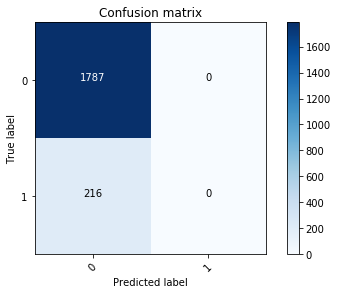

In [0]:
# # Function to plot confusion matrix    
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
sigmoid = model.predict(datasets['Xtest'])

# use 0.5 as the threshold
Y_pred = np.zeros(sigmoid.shape)
Y_pred[sigmoid >= 0.5] = 1
Y_pred = Y_pred[:, 0]
Y_true = datasets['Ytest']
confusion_mtx = confusion_matrix(Y_true, Y_pred)
 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

Text(0, 0.5, 'Fraction classified incorrectly')

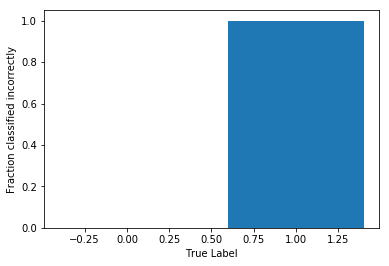

In [0]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')